# Problem Description
Tiny ImageNet contains 100'000 images of 200 classes (500 for each class) downsized to 64×64 colored images. Each class has 500 training images, 50 validation images and 50 test images.

# Metrics
For the evaluation of the model, we will use accuracy as our metric. It is straightforward and defined as follows:
$$ \text{Accuracy} = \frac{\text{correct classifications}}{\text{all classifications}} $$

However, accuracy has a disadvantage for multiclass classification problems, as it does not consider class imbalances. If our model is biased towards one class, and that class has the highest occurrence, accuracy may fail to reflect this bias. In our case, since the dataset does not have class imbalances, accuracy should be sufficient for our evaluation.

To estimate the error in the chosen metric, we could also consider using an alternative metric like the F1 Score, which penalizes false predictions rather than just summarizing the correct ones.


# Base Architecture
- The base model consists of two convolutional layers for feature extraction and two pooling layers to reduce the spatial dimension of the image. Two fully connected layer ensure enough parameters. The goal is to train with a single sample or batch and to show that it works as well as in the next step to find a proper learning rate and batch size.

In [4]:
import torch
import torch.nn as nn
from torchsummary import summary
import utils
from typing import List, Tuple, Dict


class CNN(nn.Module):
    def __init__(
        self,
        dim: int,
        num_classes: int,
        confs: List[Tuple[str, Dict]],
        in_channels: int,
        weight_init=None,
    ):
        super(CNN, self).__init__()
        self.net = nn.ModuleList()
        self.weight_init = weight_init

        # Split configurations
        linear_idxs = [idx for idx, (layer, _) in enumerate(confs) if layer == "L"]
        linear_start = linear_idxs[0]
        convolution_conf = confs[:linear_start]
        linear_conf = confs[linear_start:]

        # Process convolution layers
        current_channels = in_channels
        for layer, conf in convolution_conf:
            if layer == "C":
                print(f"Creating Conv2d: in_channels={current_channels}, out_channels={conf['channels']}")
                self.net.append(
                    nn.Conv2d(
                        current_channels,
                        out_channels=conf["channels"],
                        kernel_size=conf["kernel"],
                        stride=conf.get("stride", 1),
                        padding=conf.get("padding", 0),
                    )
                )
                self.net.append(nn.ReLU())
                if conf.get("batch_norm", False):
                    self.net.append(nn.BatchNorm2d(conf["channels"]))
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))
                current_channels = conf["channels"]
            elif layer == "P":
                self.net.append(nn.MaxPool2d(kernel_size=conf["kernel"]))

        # Calculate dimensions after convolutions
        self.dim = utils.get_dim_after_conv_and_pool(dim_init=dim, confs=convolution_conf)
        
        # Process linear layers
        for idx, (layer, conf) in enumerate(linear_conf):
            if idx == 0:
                self.net.append(nn.Flatten())
                self.net.append(
                    nn.Linear(self.dim * self.dim * current_channels, conf["units"])
                )
                self.net.append(nn.ReLU())
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))
            elif idx == len(linear_conf) - 1:
                self.net.append(nn.Linear(conf["units"], num_classes))
            else:
                self.net.append(nn.Linear(conf["units"], conf["units"]))
                self.net.append(nn.ReLU())
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))

        if self.weight_init is not None:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.net:
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                if self.weight_init == "kaiming":
                    nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                elif self.weight_init == "random":
                    nn.init.uniform_(m.weight, -0.1, 0.1)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # x comes in as [batch_size, height, width, channels] or [batch_size, channels, height, width]
        if x.shape[1] != 3:  # If channels are not in the correct position
            # print(f"Input shape before permute: {x.shape}")
            x = x.permute(0, 3, 1, 2)  # Change from (N,H,W,C) to (N,C,H,W)
            # print(f"Input shape after permute: {x.shape}")
        
        # Now x should be [batch_size, channels, height, width]
        assert x.shape[1] == 3, f"Expected 3 channels in dimension 1, got shape {x.shape}"

        for layer in self.net:
            x = layer(x)

        return x

In [5]:
confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 500}),
]

In [3]:
x = torch.rand(10, 64, 64, 3)
model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
model(x)
summary(model, (64, 64, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
              ReLU-2           [-1, 16, 62, 62]               0
         MaxPool2d-3           [-1, 16, 31, 31]               0
            Conv2d-4           [-1, 32, 29, 29]           4,640
              ReLU-5           [-1, 32, 29, 29]               0
         MaxPool2d-6           [-1, 32, 14, 14]               0
           Flatten-7                 [-1, 6272]               0
            Linear-8                  [-1, 500]       3,136,500
              ReLU-9                  [-1, 500]               0
           Linear-10                  [-1, 200]         100,200
Total params: 3,241,788
Trainable params: 3,241,788
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.57
Params size (MB): 12.37
Estima

In [4]:
train_loader, valid_loader = utils.get_data(batch_size=None)
print(train_loader, valid_loader)

<torch.utils.data.dataloader.DataLoader object at 0x106fb10c0> <torch.utils.data.dataloader.DataLoader object at 0x106fb0340>


## Discussion

# SGD, Tuning of Learning Rate and Batch Size
- Stochastic Gradient Descent (SGD) is an optimization method. Unlike traditional gradient descent, where we train on the entire dataset, SGD updates model parameters using a small batch of the data. This enables faster learning, say faster convergence to local (global) minima, and is therefore more efficient.
- The learning rate controls how much the model's weights are adjusted in response to the error at each step of training. A small learning rate increases the training time, while a large learning rate speeds up training but can cause the model to overshoot and fail to converge.
- The batch size refers to the number of training examples used for updating the model's weights. The key idea is that using smaller groups to update the weights will also allow the model to generalize well, as the batch acts as a proxy for the whole dataset.

First, we'll conduct an overfitting test by training on a small dataset of 100 samples, expecting the loss to decrease and accuracy to increase. Then, we'll search for the highest learning rate that still allows convergence. Finally, we'll determine a batch size that is memory efficient and balances representation of the data statistics with minimizing noise.

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from cnn import CNN
from utils import get_data


def eval(model, valid_loader, criterion, device=None):
    model.eval()
    loss_valid = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for imgs, labels in valid_loader:
            if imgs.dim() == 3:
                imgs = imgs.unsqueeze(0)
            if isinstance(labels, int):
                labels = torch.tensor([labels])
            if device is not None:
                imgs = imgs.to(device)
                labels = labels.to(device)
            labels = labels.long()
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss_valid += loss.item()
            preds = nn.functional.softmax(logits, dim=1)
            predicted = preds.argmax(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss_valid /= len(valid_loader)
    valid_accuracy = 100 * correct / total
    return loss_valid, valid_accuracy


def train(model, epochs, train_loader, valid_loader, criterion, optimizer, device=None):
    loss_train_hist = []
    loss_valid_hist = []
    train_accuracy_hist = []
    valid_accuracy_hist = []

    for epoch in range(epochs):
        print(
            f"|---------------------------| Start Epoch {epoch}: |---------------------------|"
        )

        # Training phase
        model.train()
        loss_train = 0
        total = 0
        correct = 0

        for imgs, labels in train_loader:
            if imgs.dim() == 3:
                imgs = imgs.unsqueeze(0)
            if isinstance(labels, int):
                labels = torch.tensor([labels])
            if device is not None:
                imgs = imgs.to(device)
                labels = labels.to(device)
            # Forward pass
            labels = labels.long()
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss_train += loss.item()
            preds = nn.functional.softmax(logits, dim=1)
            predicted = preds.argmax(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train /= len(train_loader)
        train_accuracy = 100 * correct / total

        # Evaluation phase
        valid_loss, valid_accuracy = eval(model, valid_loader, criterion, device)

        # Store metrics
        loss_train_hist.append(loss_train)
        loss_valid_hist.append(valid_loss)
        train_accuracy_hist.append(train_accuracy)
        valid_accuracy_hist.append(valid_accuracy)

        # Print metrics
        print(f"Train Loss: {loss_train:.4f} | Train Accuracy: {train_accuracy:.2f}%")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Accuracy: {valid_accuracy:.2f}%")

    return {
        "train_loss": loss_train_hist,
        "valid_loss": loss_valid_hist,
        "train_accuracy": train_accuracy_hist,
        "valid_accuracy": valid_accuracy_hist,
    }


Training length:  1
|---------------------------| Start Epoch 0: |---------------------------|
Epoch 0, Loss: 5.298584461212158
Train Loss: 5.298584461212158
Train Accuracy: 0.0
|---------------------------| Start Epoch 1: |---------------------------|
Epoch 1, Loss: 5.287440776824951
Train Loss: 5.287440776824951
Train Accuracy: 1.0
|---------------------------| Start Epoch 2: |---------------------------|
Epoch 2, Loss: 5.2762956619262695
Train Loss: 5.2762956619262695
Train Accuracy: 1.0
|---------------------------| Start Epoch 3: |---------------------------|
Epoch 3, Loss: 5.2652740478515625
Train Loss: 5.2652740478515625
Train Accuracy: 2.0
|---------------------------| Start Epoch 4: |---------------------------|
Epoch 4, Loss: 5.254425525665283
Train Loss: 5.254425525665283
Train Accuracy: 4.0
|---------------------------| Start Epoch 5: |---------------------------|
Epoch 5, Loss: 5.243680000305176
Train Loss: 5.243680000305176
Train Accuracy: 3.0
|---------------------------

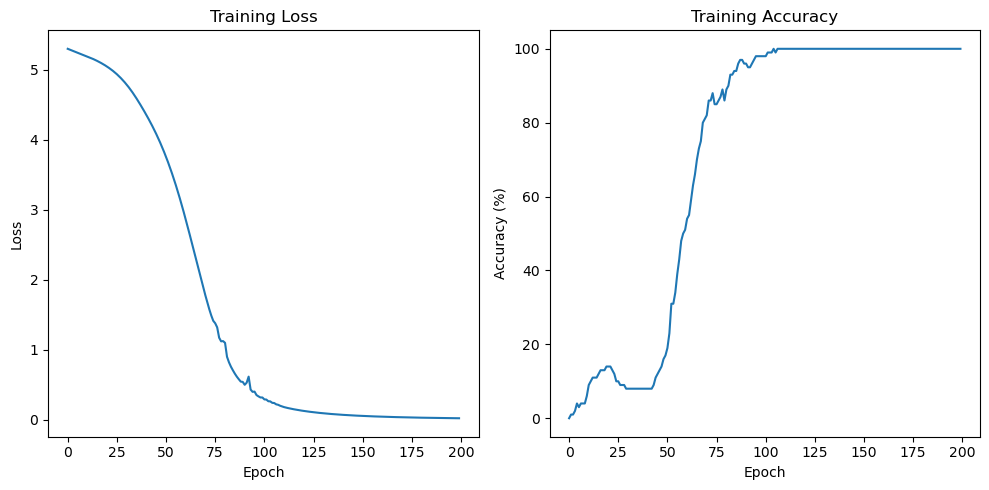

In [17]:
confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 500}),
]
model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
train_loader, valid_loader = get_data(batch_size=100, subset_size=100, seed=42)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_train, train_accuracy = train(
    model,
    epochs=200,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=None,
)
# Plot training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_train)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()


In [46]:
# TODO evaluate the model on the validation set
confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 500}),
]
device = torch.device("mps" if torch.backends.mps.is_available() else None)
criterion = nn.CrossEntropyLoss()
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [32, 64]
results = {}
epochs = 10
for lr in learning_rates:
    print(f"Learning rate: {lr}")
    for bs in batch_sizes:
        print(f"Batch size: {bs}")
        train_loader, valid_loader = get_data(batch_size=bs, seed=42)
        model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
        if device is not None:
            model.to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr)
        loss_train, train_accuracy = train(
            model,
            epochs=epochs,
            train_loader=train_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
        )
        results[(lr, bs)] = (loss_train, train_accuracy)

Learning rate: 0.0001
Batch size: 32
|---------------------------| Start Epoch 0: |---------------------------|
Train Loss: 5.299177282714844
Train Accuracy: 0.497
|---------------------------| Start Epoch 1: |---------------------------|
Train Loss: 5.2972902526855465
Train Accuracy: 0.554
|---------------------------| Start Epoch 2: |---------------------------|
Train Loss: 5.295520900268555
Train Accuracy: 0.655
|---------------------------| Start Epoch 3: |---------------------------|
Train Loss: 5.293797625732422
Train Accuracy: 0.75
|---------------------------| Start Epoch 4: |---------------------------|
Train Loss: 5.292057313842774
Train Accuracy: 0.817
|---------------------------| Start Epoch 5: |---------------------------|
Train Loss: 5.290228044128418
Train Accuracy: 0.901
|---------------------------| Start Epoch 6: |---------------------------|
Train Loss: 5.288258346557617
Train Accuracy: 0.954
|---------------------------| Start Epoch 7: |---------------------------|

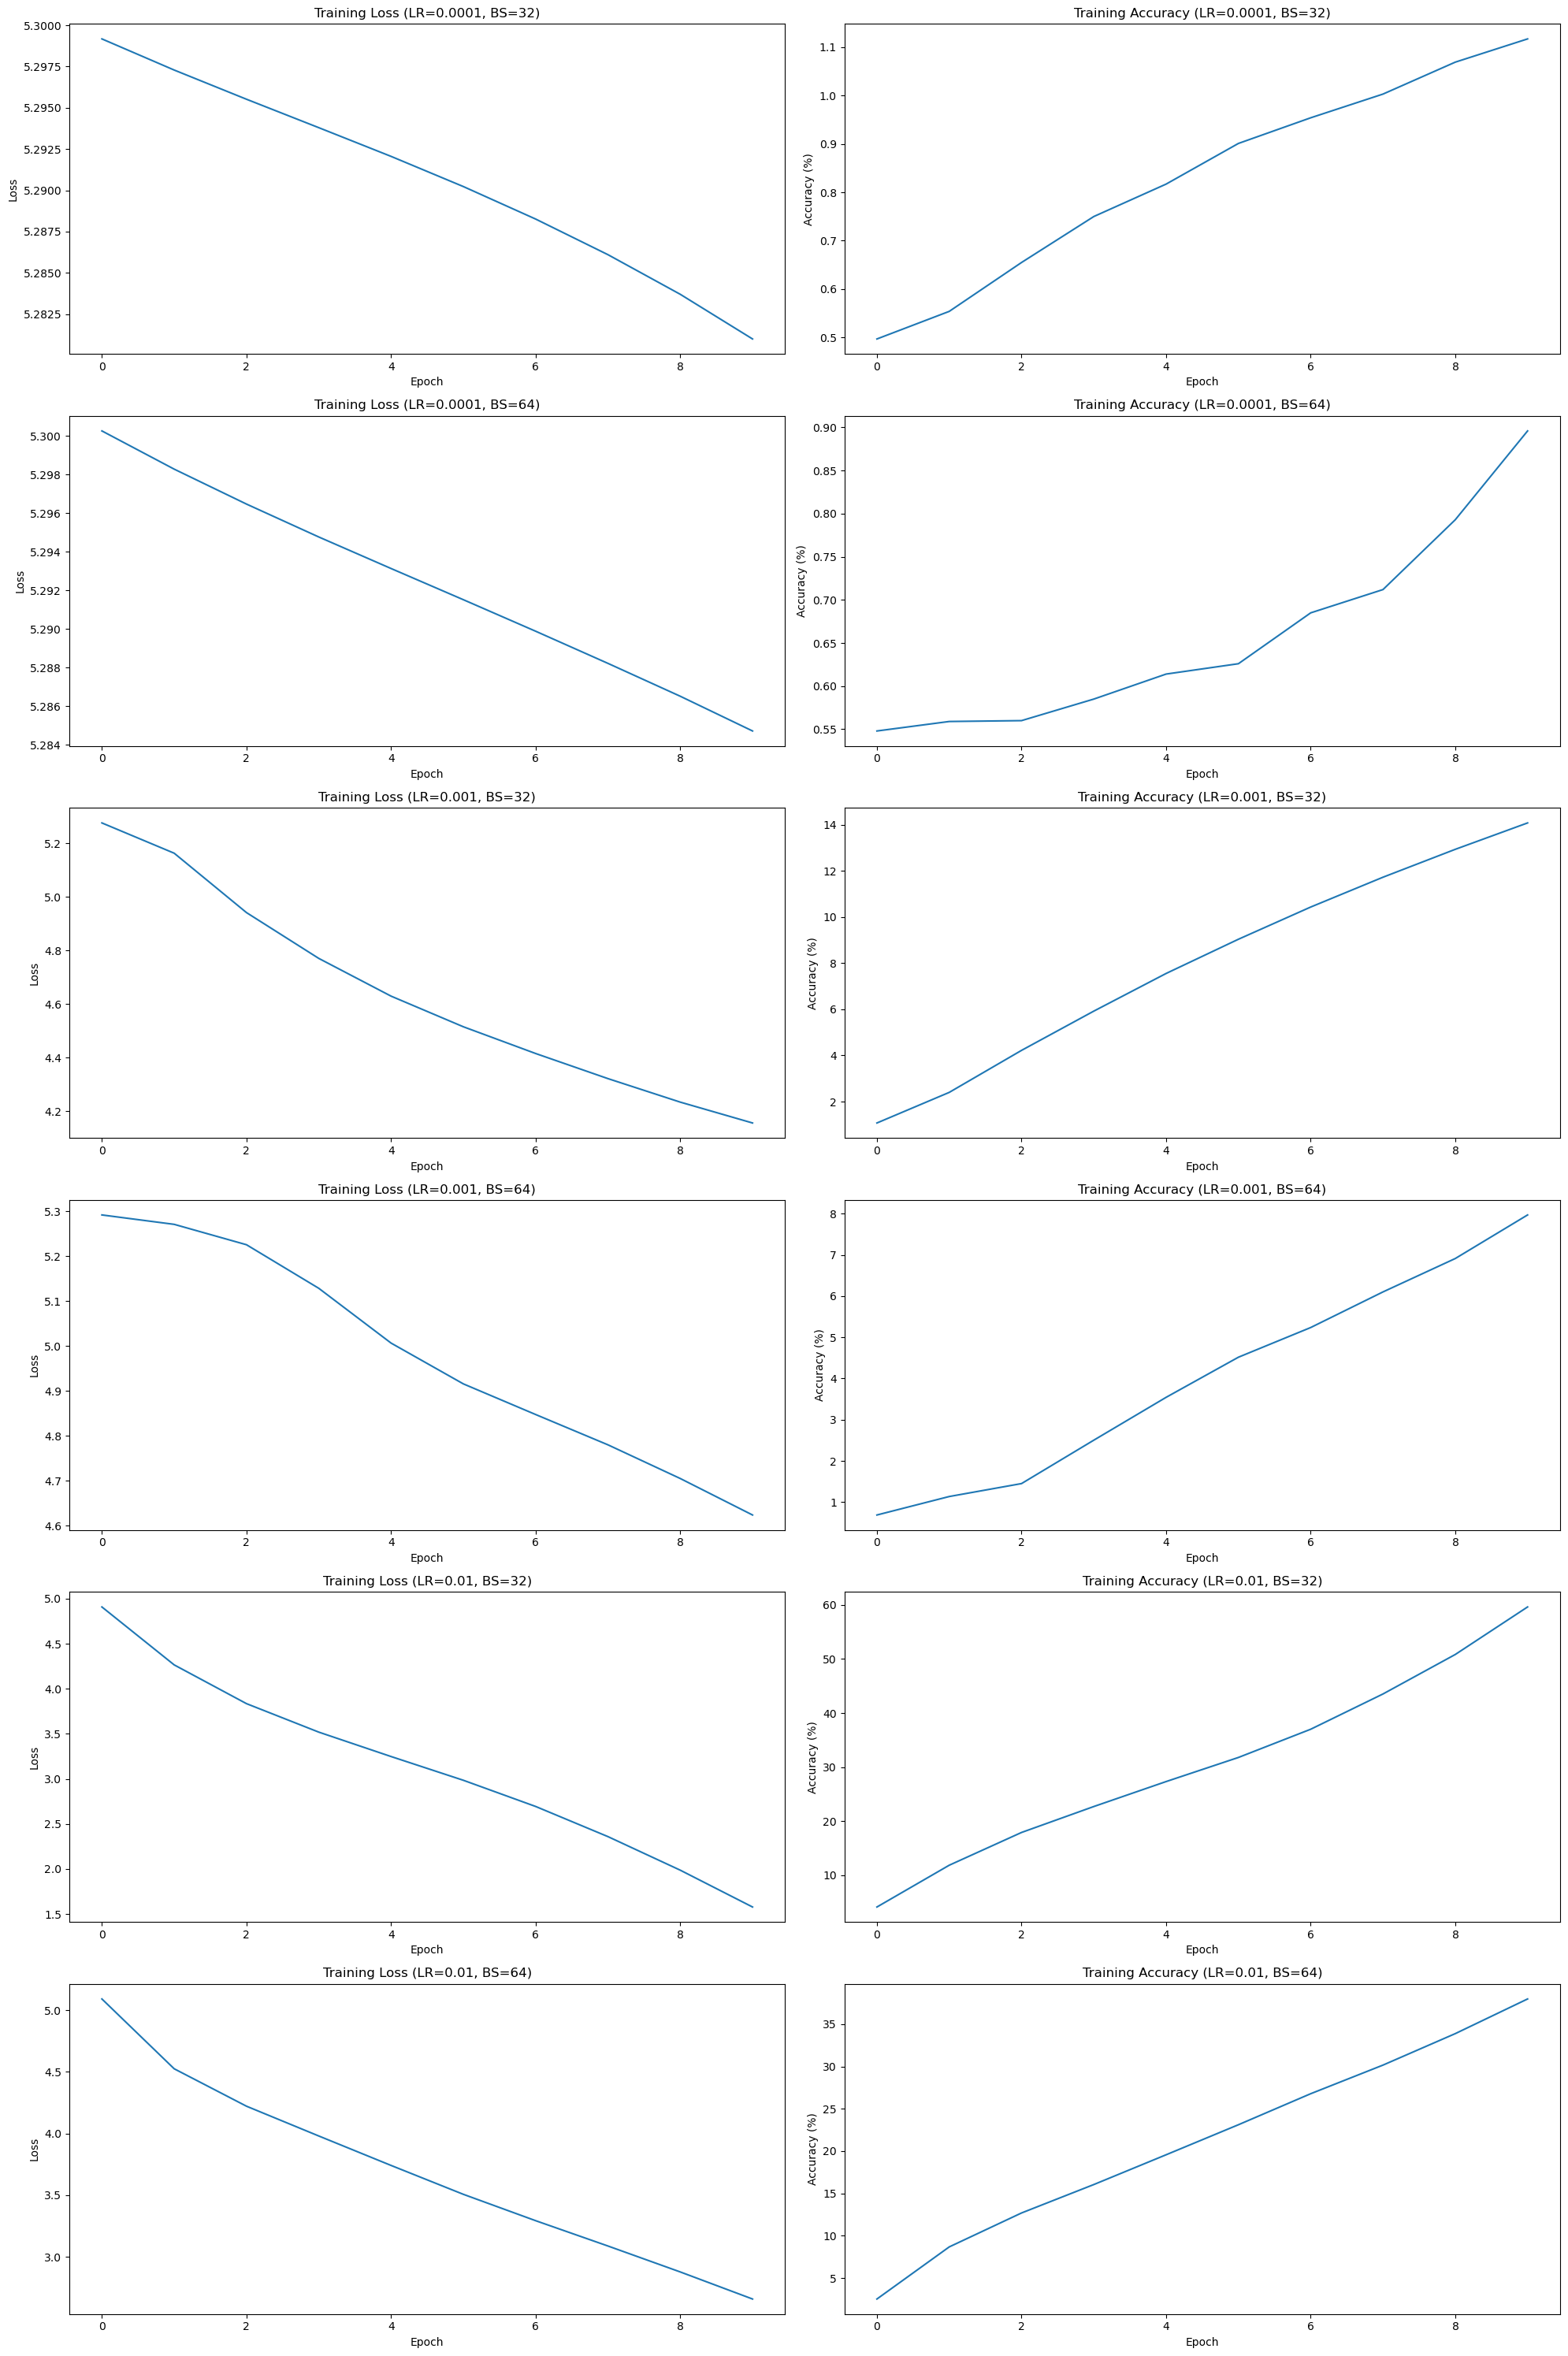

In [47]:
plt.figure(figsize=(20, 30))  # Increased figure size to accommodate more subplots
for i, ((lr, bs), (loss, accuracy)) in enumerate(results.items()):
    # Plot Training Loss
    plt.subplot(len(results), 2, 2*i + 1)
    plt.plot(loss)
    plt.title(f'Training Loss (LR={lr}, BS={bs})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot Training Accuracy
    plt.subplot(len(results), 2, 2*i + 2)
    plt.plot(accuracy)
    plt.title(f'Training Accuracy (LR={lr}, BS={bs})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

## Discussion
Our overfitting test with SGD and 100 samples (full batch) shows that the algorithm works. It convergences as expected and the accuracy increases up to 100% and shows clearly overfitting.

For the right learning rate and batch size, there are two candidates which show a proper convergence and a high increase in accuracy:

  - LR=0.001 and BS=32

    Enables more frequent gradient updates and to capture the statistics of a smaller batch size. In doing so, we hope to reduce the risk of overfitting on the training data.
    
  - LR=0.01 and BS=64
  
    Enables faster model training because a higher learning rate results in larger steps during weight updates, say speeding up convergence. A larger batch size reduces the number of gradient updates per epoch, which can make training more efficient, though it may also affect the model’s ability to generalize.

# SGD, Weight Initialization, Model Complexity, Convolution Settings
- `TODO` Explain what you will do here

## Weight Initialization `TODO`
1. **Kaiming Initialization**:
   - Weights are drawn from a normal distribution.
   - Variance is scaled by $\frac{2}{n}$, where $n$ is the number of input units in the layer.
   - This scaling helps prevent signal attenuation (very small signals) or signal explosion (very large signals) in deeper layers.

2. **Random Uniform Initialization**:
   - Weights are drawn uniformly from a fixed range, typically between \((-0.1, 0.1)\).
   - This can lead to issues in deeper networks as signals may attenuate or explode due to lack of variance scaling based on the layer's depth or size.

|---------------------------| Start Epoch 0: |---------------------------|
Train Loss: 5.298585265589217
Train Accuracy: 0.555
|---------------------------| Start Epoch 1: |---------------------------|
Train Loss: 5.297474711847762
Train Accuracy: 0.61
|---------------------------| Start Epoch 2: |---------------------------|
Train Loss: 5.29624429983072
Train Accuracy: 0.6
|---------------------------| Start Epoch 3: |---------------------------|
Train Loss: 5.294670568106654
Train Accuracy: 0.59
|---------------------------| Start Epoch 4: |---------------------------|
Train Loss: 5.292363960522051
Train Accuracy: 0.63
|---------------------------| Start Epoch 0: |---------------------------|
Train Loss: 5.298582991091207
Train Accuracy: 0.515
|---------------------------| Start Epoch 1: |---------------------------|
Train Loss: 5.297471127190148
Train Accuracy: 0.55
|---------------------------| Start Epoch 2: |---------------------------|
Train Loss: 5.296283947393155
Train Accurac

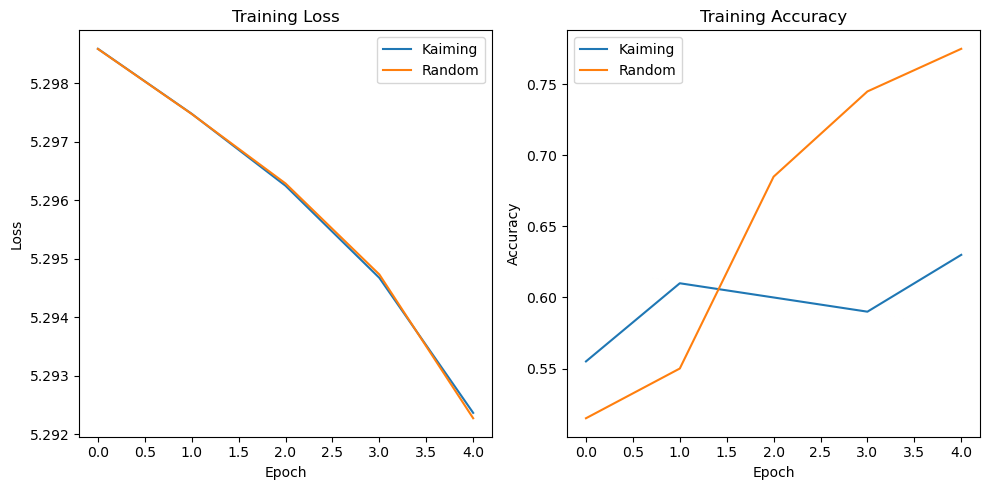

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from utils import get_data

# Define a deeper network configuration to show the effect of weight initialization
confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 64}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 500}),
    ("L", {"units": 500}),
]

device = torch.device("mps" if torch.backends.mps.is_available() else None)
train_loader, valid_loader = get_data(batch_size=64, subset_size=20000, seed=42)
criterion = nn.CrossEntropyLoss()

results = {
    "kaiming_loss": [],
    "random_loss": [],
    "kaiming_accuracy": [],
    "random_accuracy": [],
}

# Train with smaller learning rate and more epochs
for init_type in ["kaiming", "random"]:
    model = CNN(
        dim=64, 
        num_classes=200, 
        confs=confs, 
        in_channels=3, 
        weight_init=init_type
    )
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    loss, accuracy = train(
        model,
        epochs=5,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
    )
    
    results[f"{init_type}_loss"] = loss
    results[f"{init_type}_accuracy"] = accuracy

plt.figure(figsize=(10, 5))
# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(results["kaiming_loss"], label="Kaiming")
plt.plot(results["random_loss"], label="Random")
plt.legend()
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(results["kaiming_accuracy"], label="Kaiming")
plt.plot(results["random_accuracy"], label="Random")
plt.legend()
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

### Discussion

## Model Complexity
We will examine four different model variants with varying levels of complexity by adjusting the number of layers, units, or filters per layer. Additionally, we will monitor the learning curves to ensure that the training process remains stable.

I hypothesize that Tiny ImageNet will benefit from a deeper architecture—specifically, increasing the number of convolutional layers. This enhancement should enable the model to learn more complex patterns, and be get better in differentiation between 200 classes.

For the four proposed model variants, I will progressively increase the number of convolutional layers while decreasing the number of units in each dense layer. This strategy should mitigate overfitting by reducing the total number of parameters.

### Model Variant 1

**Architecture:**
- **Convolutional layers:**
  - 3x3 conv, 16 channels
  - 3x3 conv, 32 channels
  - Pooling layer with kernel size 2

- **Fully connected layers:**
  - fc 500 units
  - fc 500 units

**Evaluation:**
- This architecture includes two convolutional and two fully connected (linear) layers.
- The convolutional layers are effective for capturing spatial patterns within the input images.
- The fully connected layers, with 500 units each, significantly increase the number of parameter, which can raises the risk of overfitting.

**Future considerations:**
- Increase the number of convolutional layers.
- Reduce the number of units in the fully connected layers.

In [10]:
from train_eval import train

confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 500}),
]
model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
              ReLU-2           [-1, 16, 62, 62]               0
            Conv2d-3           [-1, 32, 60, 60]           4,640
              ReLU-4           [-1, 32, 60, 60]               0
         MaxPool2d-5           [-1, 32, 30, 30]               0
           Flatten-6                [-1, 28800]               0
            Linear-7                  [-1, 500]      14,400,500
              ReLU-8                  [-1, 500]               0
            Linear-9                  [-1, 200]         100,200
Total params: 14,505,788
Trainable params: 14,505,788
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 3.14
Params size (MB): 55.34
Estimated Total Size (MB): 58.53
-----------------------------------

In [11]:
device = torch.device("mps" if torch.backends.mps.is_available() else None)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_loader, valid_loader = get_data(batch_size=64, seed=42)
results = train(
    model,
    epochs=20,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
)

|---------------------------| Start Epoch 0: |---------------------------|
Train Loss: 4.9859 | Train Accuracy: 3.65%
Valid Loss: 4.6626 | Valid Accuracy: 6.80%
|---------------------------| Start Epoch 1: |---------------------------|
Train Loss: 4.4204 | Train Accuracy: 10.02%
Valid Loss: 4.2908 | Valid Accuracy: 11.57%
|---------------------------| Start Epoch 2: |---------------------------|
Train Loss: 4.0303 | Train Accuracy: 15.21%
Valid Loss: 4.0239 | Valid Accuracy: 14.82%
|---------------------------| Start Epoch 3: |---------------------------|
Train Loss: 3.6643 | Train Accuracy: 20.91%
Valid Loss: 3.8563 | Valid Accuracy: 17.39%
|---------------------------| Start Epoch 4: |---------------------------|
Train Loss: 3.2950 | Train Accuracy: 26.80%
Valid Loss: 3.7518 | Valid Accuracy: 19.49%
|---------------------------| Start Epoch 5: |---------------------------|
Train Loss: 2.8827 | Train Accuracy: 34.10%
Valid Loss: 3.8256 | Valid Accuracy: 18.84%
|-----------------------

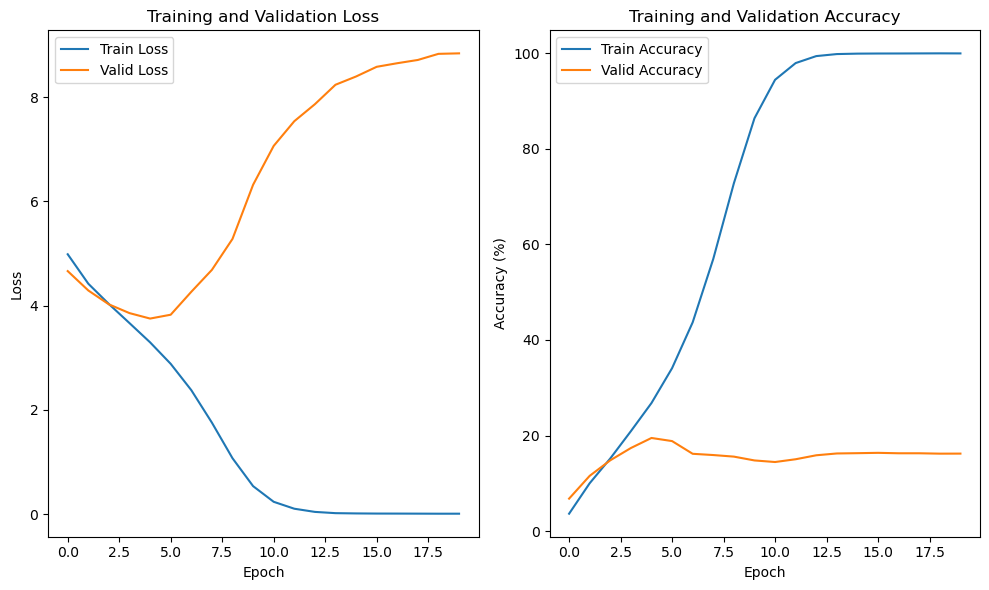

In [12]:
import importlib
import plot_train
importlib.reload(plot_train)
from plot_train import plot_train
plot_train(results)

### Model Variant 2

**Architecture Changes**:
- **Convolutional Layers**:
  - Initial layers: 3x3 conv, 16 and 3x3 conv, 32.
  - Additional layer added: 3x3 conv, 64.
- **Pooling**:
  - Two pooling layers with a stride of 2.
  - Spatial dimension reduced to 14x14.
- **Fully Connected Layers**:
  - Reduced units in the fully connected layer from 500 to 400.

**Parameter Impact**:
- The added convolutional layer with 64 filters (3x3 kernel) increases parameters by **18,400**.
- Reducing the fully connected layer units from 500 to 400 cuts linear parameters by more than half.

**Performance Expectation**:
- **Feature Extraction**: Enhanced by the added convolutional layer, increasing the depth of representation.
- **Overfitting Reduction**: Simplifying the fully connected layer may reduce overfitting.

In [7]:
from torchsummary import summary
import importlib
import cnn
importlib.reload(cnn)
from cnn import CNN
confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 64}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 400}),
]
model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
summary(model, (64, 64, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
              ReLU-2           [-1, 16, 62, 62]               0
            Conv2d-3           [-1, 32, 60, 60]           4,640
              ReLU-4           [-1, 32, 60, 60]               0
         MaxPool2d-5           [-1, 32, 30, 30]               0
            Conv2d-6           [-1, 64, 28, 28]          18,496
              ReLU-7           [-1, 64, 28, 28]               0
         MaxPool2d-8           [-1, 64, 14, 14]               0
           Flatten-9                [-1, 12544]               0
           Linear-10                  [-1, 500]       6,272,500
             ReLU-11                  [-1, 500]               0
           Linear-12                  [-1, 200]         100,200
Total params: 6,396,284
Trainable params: 6,396,284
Non-trainable params: 0
---------------------------

In [8]:
import torch
import torch.optim as optim
import torch.nn as nn
from utils import get_data
import importlib
import train_eval
importlib.reload(train_eval)
from train_eval import train

device = torch.device("mps" if torch.backends.mps.is_available() else None)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
train_loader, valid_loader = get_data(batch_size=64, seed=42)
results = train(
    model,
    epochs=20,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
)

|---------------------------| Start Epoch 0: |---------------------------|
Train Loss: 5.1771 | Train Accuracy: 1.68%
Valid Loss: 4.9041 | Valid Accuracy: 3.76%
|---------------------------| Start Epoch 1: |---------------------------|
Train Loss: 4.7730 | Train Accuracy: 5.61%
Valid Loss: 4.6530 | Valid Accuracy: 6.69%
|---------------------------| Start Epoch 2: |---------------------------|
Train Loss: 4.4356 | Train Accuracy: 9.55%
Valid Loss: 4.3696 | Valid Accuracy: 10.04%
|---------------------------| Start Epoch 3: |---------------------------|
Train Loss: 4.1248 | Train Accuracy: 13.82%
Valid Loss: 4.1350 | Valid Accuracy: 13.24%
|---------------------------| Start Epoch 4: |---------------------------|
Train Loss: 3.8637 | Train Accuracy: 17.43%
Valid Loss: 3.9437 | Valid Accuracy: 16.26%
|---------------------------| Start Epoch 5: |---------------------------|
Train Loss: 3.6052 | Train Accuracy: 21.55%
Valid Loss: 3.8283 | Valid Accuracy: 17.74%
|--------------------------

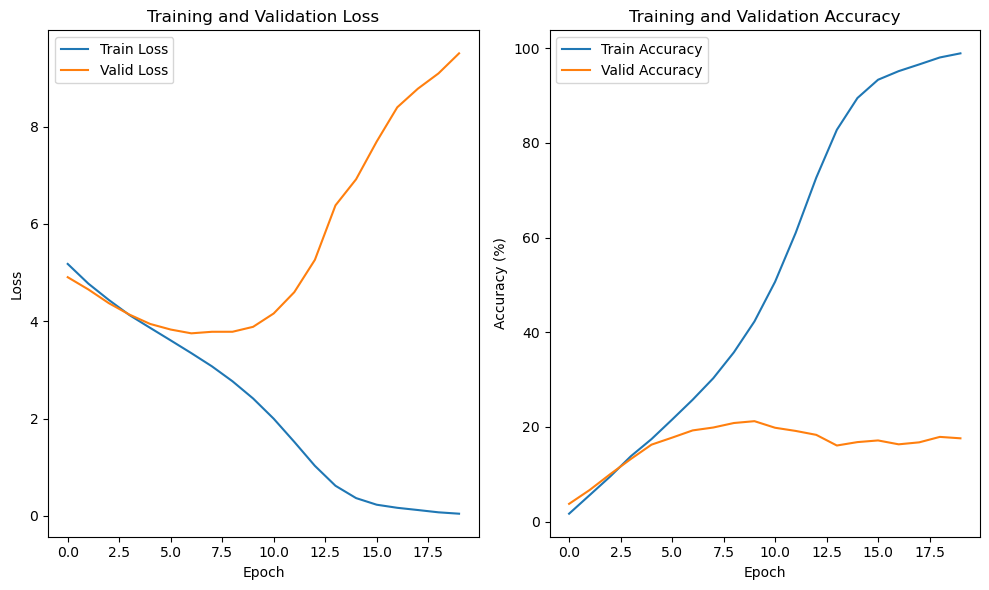

In [9]:
import importlib
import plot_train
importlib.reload(plot_train)
from plot_train import plot_train
plot_train(results)

### Model Variant 3
# Model Variant 3

### Architecture:

- **Convolution Layers**:
  - 3x3 conv, 16 channels
  - 3x3 conv, 32 channels
  - Pooling layer, stride 2
  - 3x3 conv, 64 channels
  - 3x3 conv, 64 channels
  - Pooling layer, stride 2

- **Fully Connected Layers**:
  - fc 500
  - fc 300

- **Parameter Increase**: Increased parameters in the convolutional layers from **18,400** to **36,900**, by adding consecutive convolutional layer.
- **Output Shape Comparison**: Output shape remains close to the previous architecture, adjusting from **(64, 14, 14)** to **(64, 13, 13)**.
- **Overfitting Consideration**: The depth could improve generalization.

In [4]:
from torchsummary import summary
import importlib
import cnn
importlib.reload(cnn)
from cnn import CNN
confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 64}),
    ("C", {"kernel": 3, "channels": 64}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 300}),
]
model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
summary(model, (64, 64, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
              ReLU-2           [-1, 16, 62, 62]               0
            Conv2d-3           [-1, 32, 60, 60]           4,640
              ReLU-4           [-1, 32, 60, 60]               0
         MaxPool2d-5           [-1, 32, 30, 30]               0
            Conv2d-6           [-1, 64, 28, 28]          18,496
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 26, 26]          36,928
              ReLU-9           [-1, 64, 26, 26]               0
        MaxPool2d-10           [-1, 64, 13, 13]               0
          Flatten-11                [-1, 10816]               0
           Linear-12                  [-1, 500]       5,408,500
             ReLU-13                  [-1, 500]               0
           Linear-14                  [

In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else None)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
train_loader, valid_loader = get_data(batch_size=64, seed=42)
results = train(
    model,
    epochs=20,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
)

|---------------------------| Start Epoch 0: |---------------------------|
Train Loss: 5.2954 | Train Accuracy: 0.63%
Valid Loss: 5.2812 | Valid Accuracy: 1.05%
|---------------------------| Start Epoch 1: |---------------------------|
Train Loss: 5.0353 | Train Accuracy: 2.82%
Valid Loss: 4.8412 | Valid Accuracy: 4.84%
|---------------------------| Start Epoch 2: |---------------------------|
Train Loss: 4.6847 | Train Accuracy: 6.71%
Valid Loss: 4.5742 | Valid Accuracy: 7.58%
|---------------------------| Start Epoch 3: |---------------------------|
Train Loss: 4.3941 | Train Accuracy: 10.11%
Valid Loss: 4.3410 | Valid Accuracy: 10.54%
|---------------------------| Start Epoch 4: |---------------------------|
Train Loss: 4.1414 | Train Accuracy: 13.22%
Valid Loss: 4.1514 | Valid Accuracy: 12.74%
|---------------------------| Start Epoch 5: |---------------------------|
Train Loss: 3.9073 | Train Accuracy: 16.62%
Valid Loss: 4.2937 | Valid Accuracy: 12.44%
|---------------------------

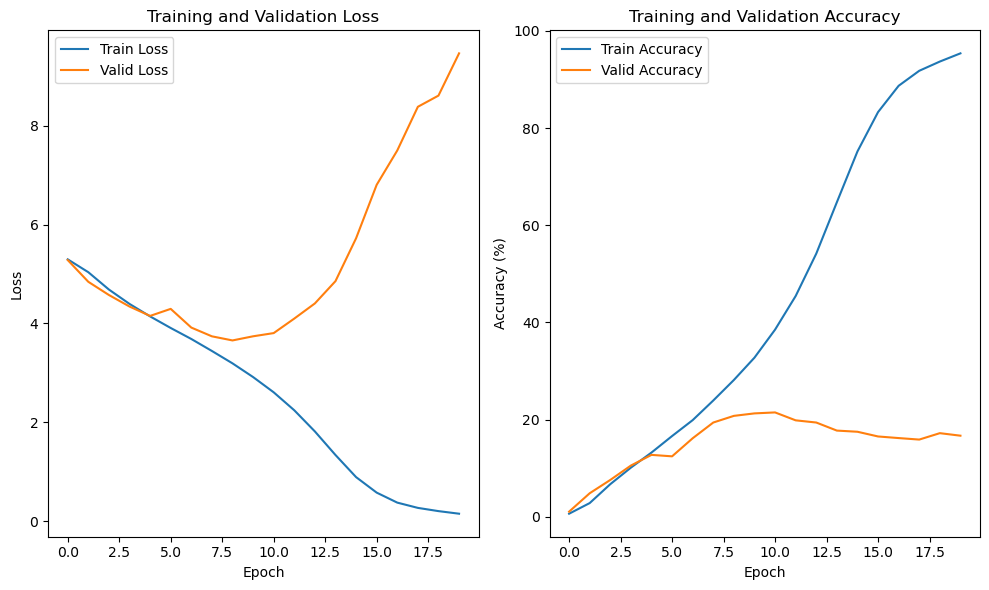

In [6]:
import importlib
import plot_train
importlib.reload(plot_train)
from plot_train import plot_train
plot_train(results)

### Model Variant 4

Architecture:

- **Convolutional Layers**:
  - **First Stage**: Two 3x3 convolutional layers with 16 and 32 channels, followed by a pooling layer (stride 2) to reduce spatial dimensions.
  - **Second Stage**: Two 3x3 convolutional layers with 64 channels, followed by a pooling layer (stride 2).
  - **Third Stage**: Two 3x3 convolutional layers with 128 channels, followed by a pooling layer (stride 2).
- **Fully Connected Layers**:
  - First fully connected layer with 500 units.
  - Second fully connected layer with 200 units.

- **Feature Extraction**: The model applies three stages of convolutional layers with increasing channel depth (16, 32, 64, and 128), interspersed with pooling layers to downsample spatial dimensions.
- **Gradual Detail Extraction**: Multiple convolutional layers before each pooling step help extract detailed features progressively while reducing spatial dimensions.
- **Output Dimensions**: Starting with an input size of (3, 64, 64) for channels, height, and width, the model outputs a final feature map of (128, 4, 4), representing a dense, high-level feature representation.
- **Parameter Count**: Approximately 1.4 million parameters, which is the lowest so far.
- **Performance Expectation**: With this setup, the model should show the best performance so far by extracting the most patterns and saving them to the feature space.


In [1]:
from torchsummary import summary
import importlib
import cnn
importlib.reload(cnn)
from cnn import CNN
confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 64}),
    ("C", {"kernel": 3, "channels": 64}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 128}),
    ("C", {"kernel": 3, "channels": 128}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 200}),
]
model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
summary(model, (64, 64, 3))

/Users/hariveliki/miniconda3/envs/eml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/hariveliki/miniconda3/envs/eml/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/hariveliki/miniconda3/envs/eml/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/hariveliki/miniconda3/envs/eml/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <578455F2-C28A-3E71-B792-09499A54E249> /Users/hariveliki/miniconda3/envs/eml/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
              ReLU-2           [-1, 16, 62, 62]               0
            Conv2d-3           [-1, 32, 60, 60]           4,640
              ReLU-4           [-1, 32, 60, 60]               0
         MaxPool2d-5           [-1, 32, 30, 30]               0
            Conv2d-6           [-1, 64, 28, 28]          18,496
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 26, 26]          36,928
              ReLU-9           [-1, 64, 26, 26]               0
        MaxPool2d-10           [-1, 64, 13, 13]               0
           Conv2d-11          [-1, 128, 11, 11]          73,856
             ReLU-12          [-1, 128, 11, 11]               0
           Conv2d-13            [-1, 128, 9, 9]         147,584
             ReLU-14            [-1, 12

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
from utils import get_data
from train_eval import train

device = torch.device("mps" if torch.backends.mps.is_available() else None)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
train_loader, valid_loader = get_data(batch_size=64, seed=42)
results = train(
    model,
    epochs=20,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
)

|---------------------------| Start Epoch 0: |---------------------------|
Train Loss: 5.2986 | Train Accuracy: 0.58%
Valid Loss: 5.2982 | Valid Accuracy: 0.74%
|---------------------------| Start Epoch 1: |---------------------------|
Train Loss: 5.2982 | Train Accuracy: 0.68%
Valid Loss: 5.2977 | Valid Accuracy: 0.78%
|---------------------------| Start Epoch 2: |---------------------------|
Train Loss: 5.2970 | Train Accuracy: 0.62%
Valid Loss: 5.2945 | Valid Accuracy: 0.63%
|---------------------------| Start Epoch 3: |---------------------------|
Train Loss: 5.2648 | Train Accuracy: 0.77%
Valid Loss: 5.1999 | Valid Accuracy: 1.30%
|---------------------------| Start Epoch 4: |---------------------------|
Train Loss: 5.0880 | Train Accuracy: 1.88%
Valid Loss: 5.0140 | Valid Accuracy: 2.40%
|---------------------------| Start Epoch 5: |---------------------------|
Train Loss: 4.9646 | Train Accuracy: 3.06%
Valid Loss: 4.9136 | Valid Accuracy: 3.62%
|---------------------------| Star

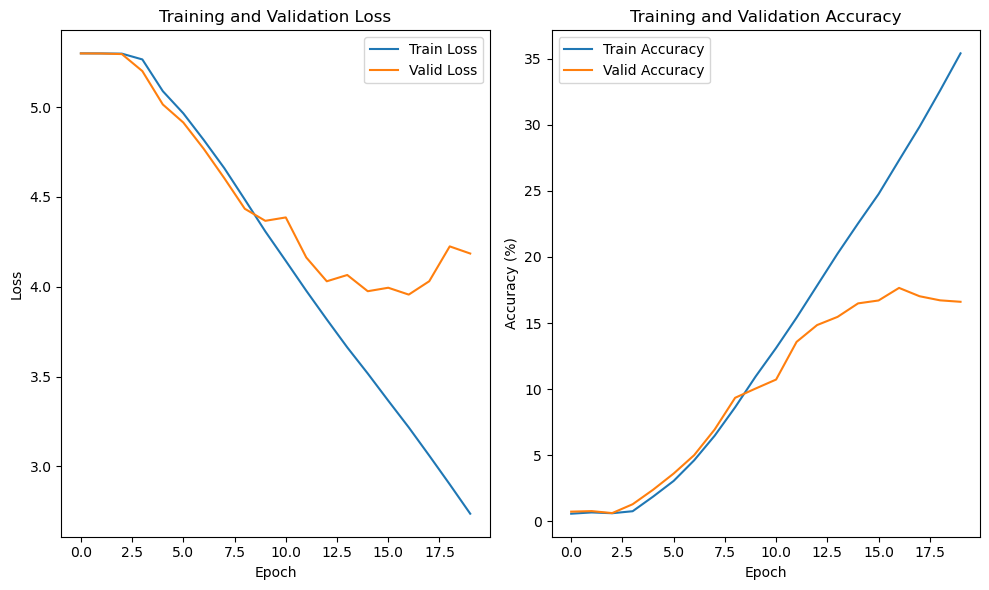

In [3]:
import importlib
import plot_train
importlib.reload(plot_train)
from plot_train import plot_train
plot_train(results)

### Discussion

- Comparing the training and validation loss/accuracy plots from the first to the fourth model variant reveals:
  - The gap between training and validation loss narrows.
  - The same trend is observed for training and validation accuracy.
  - While the validation loss increased after 5 epochs in the first model, it only rises after 15 epochs in the last model.
  - Although accuracy on the training set reached 100% for the first three variants, the last layer achieves a maximum accuracy of 35% after 20 epochs.
  - The validation accuracy increases alongside the training accuracy, achieving the narrowest gap, but still remains between 15% and 20%.

The steady improvements from the first to the last variant are due to:
  - Increasing the number of convolutional layers, which expands the feature space and extracts more patterns from the images.
    - This increases the overall parameters only slightly compared to fully connected layers.
  - Reducing the units in the fully connected layers, decreasing the total parameters from 14.4 million to 1 million. This simplification prevents the model from overfitting.

# Regularization
- Briefly describe what the goal of regularization methods in general is

## L1/L2
- Explain

In [11]:
def my_code():
    pass

## Dropout
- Explain

In [12]:
def my_code():
    pass

## Discussion
- To what extent is this goal achieved in the given case?

# Batchnorm (without REG, with SGD)
- Evaluate whether Batchnorm is useful. Describe what the idea of BN is, what it is supposed to help.

In [13]:
def my_code():
    pass

## Discussion

# Adam
- Explain

## Without BN, without REG
- Explain

In [14]:
def my_code():
    pass

## Without BN, with REG
- Explain

In [15]:
def my_code():
    pass

## Discussion

# Transfer Learning
- Explain

In [16]:
def my_code():
    pass

## Discussion

# Conclusion